# EDA

## Imports

In [48]:
%run "../config/local.ipynb"
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tqdm.notebook as tq
import math
import xml.etree.ElementTree as ET
import pandas as pd

## Features

In [30]:
features = os.listdir(ORIGINAL_FEATURES_DIR)

## Display some features

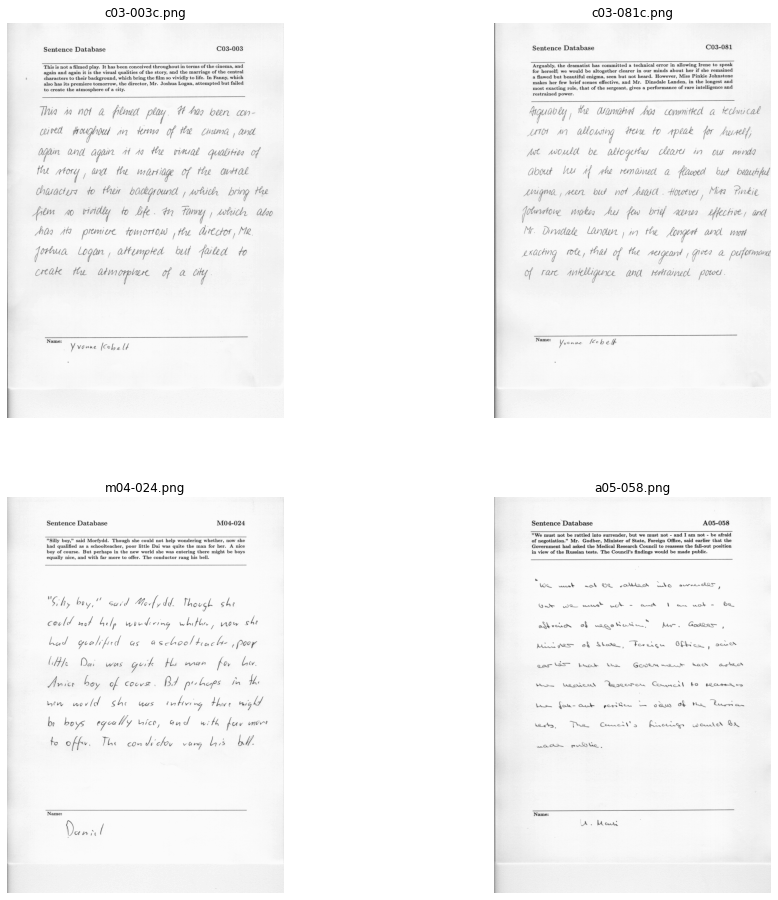

In [3]:
grid_size = (2,2)

plt.figure(figsize=(16,16))

indexes = np.random.choice(range(len(features)), size=grid_size[0]*grid_size[1], replace=False)

for i in range(grid_size[0]*grid_size[1]):
    plt.subplot(grid_size[0],grid_size[1],i+1)
        
    idx = indexes[i]    
    img_name = features[idx]
    img_path = os.path.join(ORIGINAL_FEATURES_DIR, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(img_name)
    plt.axis('off')
    
plt.show()

The features are composed by images of pages with handwritten text.

### About the files

In [4]:
idx = randint(0,len(features))
img_name = features[idx]
img_path = os.path.join(ORIGINAL_FEATURES_DIR, img_name)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print("img shape: ", img.shape)

img shape:  (3542, 2479)


The images are in a pretty high resolution. In order to facilitate the learning on the image, the image must be cropped.   

### Colors

#### Colors levels

In [5]:
colors_quantities = np.zeros((255))

img_flattened = img.flatten()

for i in tq.tqdm(range(len(img_flattened)), total=len(img_flattened)):    
    value = img_flattened[i]
    colors_quantities[value] += 1
    
colors_quantities = colors_quantities.astype(int)

#### One image analysis

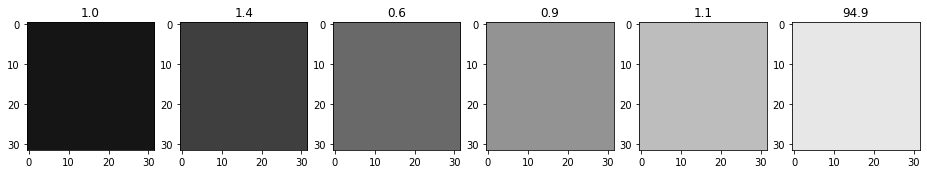

In [6]:
plt.figure(figsize=(16,6))
grid_size = (1,6)
range_length = math.floor(len(colors_quantities) / (grid_size[0]*grid_size[1]))
total = colors_quantities.sum()
m = np.zeros((10,10))
ratios = np.zeros((len(features)))

for i in range(grid_size[0]*grid_size[1]):   
    plt.subplot(grid_size[0],grid_size[1],i+1)
    from_idx = i * range_length
    to_idx = (i+1) * range_length
    sample = colors_quantities[from_idx:to_idx]
    img = np.full((32,32), math.floor((from_idx+to_idx)/2))
    ratio = round(sample.sum()*100/total,1)
    
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(ratio)            

#### Whole features analysis

In [7]:
colors_quantities = np.zeros((255))

# for each feature
for i in tq.tqdm(range(len(features[:100])), total=len(features[:100])):    
    # read the image    
    img = cv2.imread(os.path.join(ORIGINAL_FEATURES_DIR, features[i]), cv2.IMREAD_GRAYSCALE)
    img_flattened = img.flatten()
       
    values = [len(img[img == value]) for value in range(255)]    
    colors_quantities += values
    
colors_quantities = colors_quantities.astype(int)

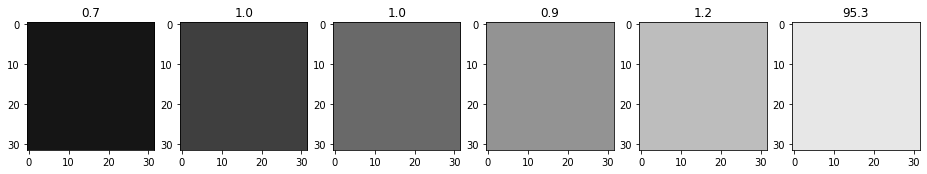

In [8]:
plt.figure(figsize=(16,6))
grid_size = (1,6)
range_length = math.floor(len(colors_quantities) / (grid_size[0]*grid_size[1]))
total = colors_quantities.sum()
m = np.zeros((10,10))

for i in range(grid_size[0]*grid_size[1]):   
    plt.subplot(grid_size[0],grid_size[1],i+1)
    from_idx = i * range_length
    to_idx = (i+1) * range_length
    sample = colors_quantities[from_idx:to_idx]
    img = np.full((32,32), math.floor((from_idx+to_idx)/2))
    ratio = round(sample.sum()*100/total,1)
    
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(ratio) 

### Downscale the image

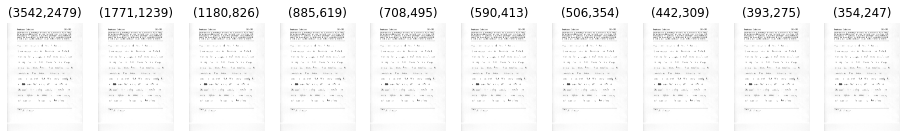

In [27]:
grid_size = (1,10)

plt.figure(figsize=(16,16))

indexes = np.random.choice(range(len(features)), size=grid_size[0]*grid_size[1], replace=False)

idx = randint(0,len(features))
img_name = features[idx]
img_path = os.path.join(ORIGINAL_FEATURES_DIR, img_name)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

for i in range(grid_size[0]*grid_size[1]):
    plt.subplot(grid_size[0],grid_size[1],i+1)
        
    dim = (int(img.shape[0]/(i+1)), int(img.shape[1]/(i+1)))
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST)
    cv2.imwrite(os.path.join("/tmp", "{}_{}x{}.png".format(img_name[:-3], dim[0],dim[1])), resized) 
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title("({},{})".format(dim[0],dim[1]))
    plt.axis('off')
    
plt.show()

#### Resize all images

In [31]:
for i in tq.tqdm(range(len(features)), total=len(features)):    
    img_path = os.path.join(ORIGINAL_FEATURES_DIR, features[i])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # scale factor 
    try:
        scale_factor = 512 / img.shape[0]
    except:
        print("feature: ", features[i])
        continue
        
    resized = cv2.resize(img, (0,0), fx=scale_factor, fy=scale_factor, interpolation = cv2.INTER_NEAREST)
    
    patched = np.full((512,512), resized[0,0])
    margin_left = int((patched.shape[1] - resized.shape[1]) / 2)
    
    patched[:, margin_left:margin_left + resized.shape[1]] = resized
    
    cv2.imwrite(os.path.join(RESIZED_512x512_FEATURES_DIR, features[i]), patched) 
    
    

In [ ]:
img_path = os.path.join(ORIGINAL_FEATURES_DIR, feature)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

## Labels

In [38]:

tree = ET.parse(os.path.join(XML_LABELS_DIR, features[0].replace(".png", ".xml")))
root = tree.getroot()

In [39]:
for child in root:
    print(child.tag, child.attrib)

machine-printed-part {}
handwritten-part {}


In [76]:
chars = []

for word in root.iter('word'):        
    for char in word.iter('cmp'):
        if int(char.attrib['width']) < 60:
            chars.append(char.attrib)
        
df = pd.DataFrame(chars)

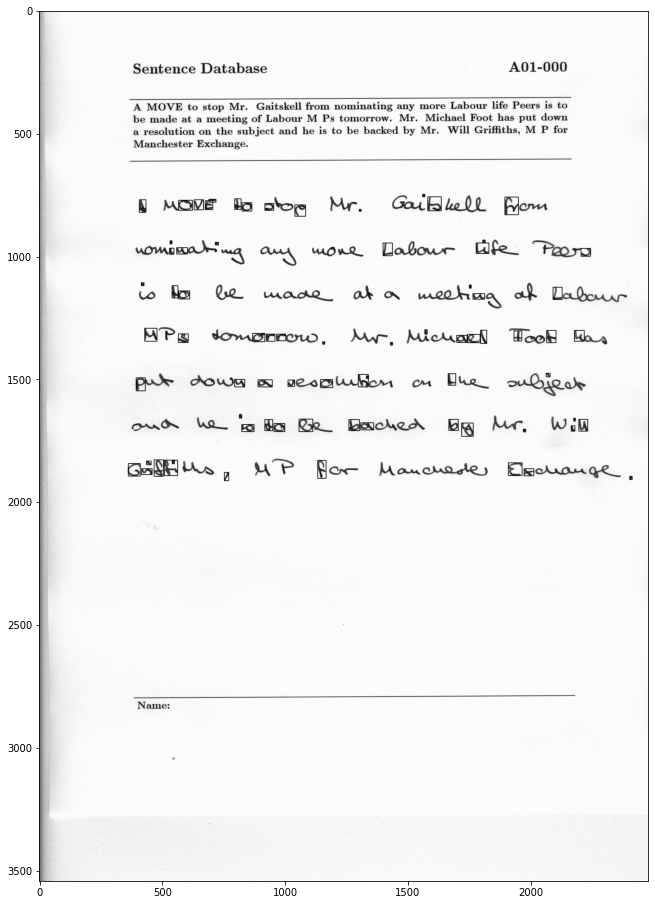

In [77]:
img_path = os.path.join(ORIGINAL_FEATURES_DIR, features[0])
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
for idx, row in df.iterrows():
    start_point = (int(row['x']),int(row['y']))
    end_point = (int(row['x'])+int(row['width']), int(row['y']) + int(row['height']))
    color = (0, 0, 0)

    # img = cv2.rectangle(img, (10,10), (20,20), (0,0,0), 2)
    img = cv2.rectangle(img, start_point, end_point, color, 2)
    
plt.figure(figsize=(16,16))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
